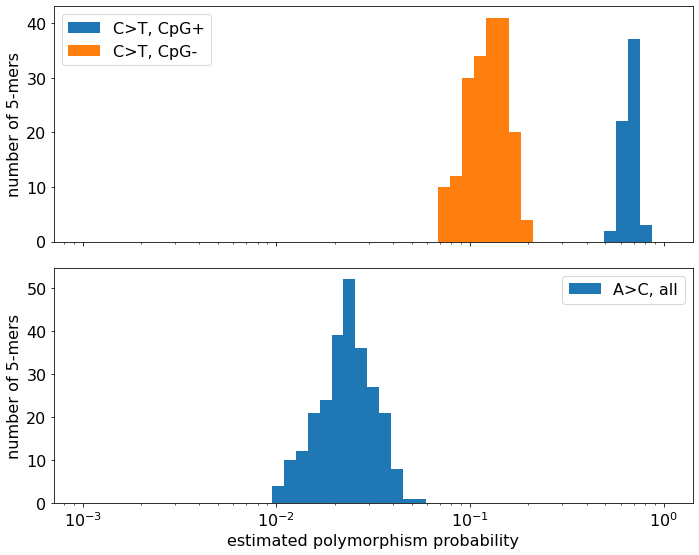

In [3]:
import json 
import numpy as np 
import matplotlib.pyplot as plt 

import sys
sys.path.append('/scratch/ucgd/lustre-work/quinlan/u6018199/constraint-tools/utilities')

from kmer import CpG, middle_base

def kmer_size(kmer_probabilities): 
    for kmer in kmer_probabilities.keys(): 
        return len(kmer)

def create_ylabel(ax, kmer_probabilities): 
    ax.set_ylabel('number of {}-mers'.format(kmer_size(kmer_probabilities)))

def plot_kmer_probabilities(model): 
  with open(model, 'r') as fh:
    kmer_probabilities = json.load(fh)['kmerProbabilities']

  C_to_T_CpGpositive_probabilities = []
  C_to_T_CpGnegative_probabilities = []
  A_to_C_probabilities = []
  for kmer, probabilities in kmer_probabilities.items():         
    if middle_base(kmer) == 'C':
      if CpG(kmer): 
        C_to_T_CpGpositive_probabilities.append(probabilities['{T}'])
      else: 
        C_to_T_CpGnegative_probabilities.append(probabilities['{T}'])
    if middle_base(kmer) == 'A':
      A_to_C_probabilities.append(probabilities['{C}'])

  plt.rcParams.update({'font.size': 16})    
  fig, axs = plt.subplots(2, 1, sharex=True, tight_layout=True)
  fig.set_size_inches(10, 8)
  logbins = np.logspace(np.log10(1e-3), np.log10(1e0) , 50)
  axs[0].hist(C_to_T_CpGpositive_probabilities, bins=logbins, label='C>T, CpG+')
  axs[0].hist(C_to_T_CpGnegative_probabilities, bins=logbins, label='C>T, CpG-')
  axs[0].legend()
  axs[1].hist(A_to_C_probabilities, bins=logbins, label='A>C, all')
  axs[1].legend()
  plt.xscale('log')
  plt.xlabel('estimated polymorphism probability')
  create_ylabel(axs[0], kmer_probabilities)
  create_ylabel(axs[1], kmer_probabilities)
    
plot_kmer_probabilities(
  '/scratch/ucgd/lustre-work/quinlan/u6018199/constraint-tools/dist/model-germline-grch38.json'
)



Compare the plots above with Fig 2 of Aggarwala and Voight 2016